<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Segment customers of a website - P5</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Modeling notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import squarify
from statsmodels.graphics.gofplots import qqplot

## df_analysis
import io
import gc
import timeit
import math
from math import pi
from collections import Counter
from math import prod
import scipy.stats as stats

## Scikit Learn 
from sklearn.preprocessing import (FunctionTransformer, QuantileTransformer, 
                                   StandardScaler, RobustScaler, OrdinalEncoder,
                                  MinMaxScaler)
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (davies_bouldin_score, silhouette_score,
                             silhouette_samples, homogeneity_score,
                             completeness_score, v_measure_score,
                             adjusted_rand_score, adjusted_mutual_info_score)

## Yellowbrick - Scikit Learn 
from yellowbrick.cluster import intercluster_distance

# Own specific functions 
from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print(82 * '_')
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
            
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print(82 * '_')
            elif type_analysis == "complete" and (df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0):
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print(82 * '_')
            
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            
            if df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0:
                del [[df_resume, df_desc]]
            else:
                del [[df_resume]]
            
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            

def normality_test(df):
    """
    Method used to make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64" or df[col].dtypes == "int64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)
    
            
def number_of_cluster(df, name_df):
    """
    Method used to calculate the number of cluster through differents metrics

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        
        Metrics:
        -----------------
            WSSE (dict): Within-Cluster-Sum of Squared Errors. Number of cluster by iteration
            davies_bouldin (dict): Davies-Bouldin score. Number of cluster by iteration
            silhouette (dict): The mean Silhouette Coefficient of all samples. Number of cluster by iteration
        
        Returns:
    -----------------
        None. 
        Plot the result. 
    """
    
    WSSE, davies_bouldin, silhouette = ({} for i in range(3))
    
    for i in range(2, 10):
        
        kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=10).fit(df)
        
        clusters = kmeans.labels_
        WSSE[i] = kmeans.inertia_ 
        davies_bouldin[i] = davies_bouldin_score(df, clusters)
        silhouette[i] = silhouette_score(df, clusters)
        
    # Plotting the result   
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 5))

    fig.suptitle("Number of cluster - " + name_df, size=25, fontweight="bold", y=1.01)

    ax1.plot(list(WSSE.keys()), list(WSSE.values()), color="blue", marker="o")
    ax1.set_title("Within-Cluster-Sum of Squared Errors", fontdict={ "fontsize": 15})
    ax1.set_xlabel("Number of cluster")
    ax1.set_ylabel("WSSE")

    ax2.plot(list(davies_bouldin.keys()), list(davies_bouldin.values()), color="red", marker="o")
    ax2.set_title("Davies-Bouldin score", fontdict={ "fontsize": 15})
    ax2.set_xlabel("Number of cluster")
    ax2.set_ylabel("Davies-Bouldin values")

    ax3.plot(list(silhouette.keys()), list(silhouette.values()), color="gold", marker="o")
    ax3.set_title("Silhouette score", fontdict={ "fontsize": 15})
    ax3.set_xlabel("Number of cluster")
    ax3.set_ylabel("Silhouette score")
    
    plt.tight_layout()
    plt.savefig("images/Number-of-cluster-" + name_df + ".png", bbox_inches="tight")
    sns.despine(fig)  
    plt.show()
    
    
def silhoutte_analysis(X):
    """
    Method used to make the silhoutte analysis

    Parameters:
    -----------------
        X (pandas.DataFrame): Dataset to analyze
        
        Returns:
    -----------------
        None. 
        Plot the result. 
    """
    
    range_n_clusters = range(2, 10)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    
    
def benchmark_kmeans(name, kmeans, n_clusters, data, labels_true):
    """
    Method used to calculate the KMeans benchmark considering differents metrics
    based on external and internal information

    Parameters:
    -----------------
        name (str): Name of the setup
        kmeans (class sklearn.cluster.KMeans): Model KMeans initialized
        n_clusters (int): Number of cluster. It is the same number of n_clusters in kmeans
        data (pandas.DataFrame): Dataset to analyze
        labels_true (arr): ground truth class labels to be used as a reference
        
        Returns:
    -----------------
        None. 
        Print the result. 
    """
    
    start_time_model = timeit.default_timer()
    cluster_labels = kmeans.fit_predict(data)
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    
    results = [name, n_clusters, end_time_model, kmeans.inertia_]
    
    # The silhouette score requires the full dataset
    results += [
        silhouette_score(data, cluster_labels)
    ]
        
    # Metrics which require only the true labels and estimator labels
    clustering_metrics = [
        homogeneity_score,
        completeness_score,
        v_measure_score,
        adjusted_rand_score,
        adjusted_mutual_info_score,
    ]
    
    results += [m(labels_true, kmeans.labels_) for m in clustering_metrics]
    
    
    formatter_result = ("{:<15} {:<10} {:}s {:>10.0f} {:>12.3f}"
                        "{:>13.3f} {:>11.3f} {:>10.3f} {:>10.3f} {:>10.3f}")

    print(formatter_result.format(*results))
    

def df_spider_RFM(df, label_score, color):
    
    """
    Method used to plot RFM through spider plot

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to plot
        label_score (str): Segmentation
        color: (dict): Color for each segmentation
        
    Returns:
    -----------------
        None. 
        PLot the RFM Segmentation. 
    """
    
    # Grouping the mean based on rfm_score_label
    df_to_plot = df.groupby([label_score]).agg("mean").reset_index()
    
    # Data Standarization
    df_to_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_to_plot[["recency", "frequency", "monetary"]]), 
                                  columns=list(df_to_plot[["recency", "frequency", "monetary"]].columns),
                                  index=df_to_plot[["recency", "frequency",	"monetary"]].index)
    
    # Concatenating the rfm score label
    df_to_plot_std = pd.concat([df_to_plot_std, df_to_plot[[label_score]]], axis=1)
    df_to_plot_std = df_to_plot_std[[label_score, "recency", "frequency", "monetary"]]
    
    # number of variable
    variables = list(df_to_plot_std)[1:]
    N = len(variables)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig = plt.figure(1, figsize=(18, 20))
    
    for i, segment in enumerate(df[label_score].unique()):
        
        ax = fig.add_subplot(4, 3, i + 1, polar=True)
        
        # We are going to plot the first line of the data frame.
        # But we need to repeat the first value to close the circular graph:
        values = list(df_to_plot_std.loc[i][["recency", "frequency", "monetary"]].values)
        values += values[:1]
        
        ax.set_title(segment, color=color[segment], fontdict={ "fontsize": 15, "fontweight": "bold" })
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)
        
        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], variables, color="grey", size=8)
        ax.set_xticklabels(variables, size=12)
        ax.set_rlabel_position(0)
        
        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5], ["-1.5", "-1", "-0.5", "0", "0.5", "1", "1.5"], color="grey", size=7)
        plt.ylim(-1.5, 1.5)
        
        # Plot data
        ax.plot(angles, values, color[segment], "o-", linewidth=1, linestyle="solid")

        # Fill area
        ax.fill(angles, values, color[segment], alpha=.25)

    # Show the graph
    plt.savefig("images/RFM-spider-segmentation-clusters.png")
    plt.show()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to load the dateset resulting from the RFM
</div>

In [3]:
df_data = pd.read_csv(r"datasets\data_to_model_refactoring.csv")

In [4]:
df_data.head()

customer_unique_id  recency  frequency  monetary  \
0  dc4b0942fb780633d44f4f73ff69dd92        6      False     37.46   
1  11ccf36669e0483ac53abfeb566679b6        7      False     67.58   
2  2fc09b16746a702ba0aab85c6a9a7438       11      False     20.38   
3  4ecdb958c2b1b099ed5e56d9ca156773       13      False    292.63   
4  164b46961e3ef442750fed496929369f       13      False    138.95   

   satisfaction rfm_score_label  fashion  furniture  others  electronics  \
0           5.0   New Customers      0.0        0.0   100.0          0.0   
1           5.0   New Customers      0.0        0.0   100.0          0.0   
2           5.0   New Customers      0.0        0.0   100.0          0.0   
3           5.0       Promising      0.0        0.0   100.0          0.0   
4           5.0       Promising      0.0        0.0   100.0          0.0   

   sports_leisure  home  construction  
0             0.0   0.0           0.0  
1             0.0   0.0           0.0  
2             0.0   0.0           0.0  
3             0.0   0.0           0.0  
4             0.0   0.0           0.0

In [5]:
df_analysis(df_data, "df_data", type_analysis="complete")


Analysis of df_data dataset
__________________________________________________________________________________
- Dataset shape:                  66934 rows and 13 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 6.2+ MB )
__________________________________________________________________________________


name     type  records  unique  # NaN   % NaN      mean  \
0   customer_unique_id   object    66934   66934      0 0.00000       NaN   
1              recency    int64    66934     318      0 0.00000 160.54345   
2            frequency     bool    66934       2      0 0.00000       NaN   
3             monetary  float64    66934   25504      0 0.00000 147.67983   
4         satisfaction  float64    66934      26      0 0.00000   4.07370   
5      rfm_score_label   object    66934      10      0 0.00000       NaN   
6              fashion  float64    66934     393      0 0.00000  24.13891   
7            furniture  float64    66934     454      0 0.00000  17.01780   
8               others  float64    66934     406      0 0.00000  16.16010   
9          electronics  float64    66934     244      0 0.00000  16.63505   
10      sports_leisure  float64    66934     263      0 0.00000  12.68015   
11                home  float64    66934     253      0 0.00000   7.49177   
12        construction  float64    66934     219      0 0.00000   5.87622   

       min      25%       50%       75%        max       std  
0      NaN      NaN       NaN       NaN        NaN       NaN  
1  0.00000 84.00000 162.00000 235.00000  320.00000  88.82827  
2      NaN      NaN       NaN       NaN        NaN       NaN  
3  9.59000 62.91000 107.68500 176.85973 6081.54000 151.14875  
4  1.00000  4.00000   5.00000   5.00000    5.00000   1.35355  
5      NaN      NaN       NaN       NaN        NaN       NaN  
6  0.00000  0.00000   0.00000   0.00000  100.00000  42.64764  
7  0.00000  0.00000   0.00000   0.00000  100.00000  37.38180  
8  0.00000  0.00000   0.00000   0.00000  100.00000  36.63241  
9  0.00000  0.00000   0.00000   0.00000  100.00000  37.14344  
10 0.00000  0.00000   0.00000   0.00000  100.00000  33.14959  
11 0.00000  0.00000   0.00000   0.00000  100.00000  26.17471  
12 0.00000  0.00000   0.00000   0.00000  100.00000  23.36947

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Dimensionality Reduction</h2>
</div>

<div class="alert alert-block alert-info">
    <p>For the <b>Dimensionality Reduction</b> we are going to work as follow</p>
    <ol>
        <li>One dataset with only feautures of <b>RFM</b>, called (REDUCED)
            <ul style="list-style-type: disc;">
                <li>recency</li>
                <li>frequency</li>
                <li>monetary</li>
            </ul> 
        </li>
        <li>Another dataset with <b>all features</b>, called (COMPLETED)</li>
    </ol> 
    <p>It is necessary to say that we are not going to select <b>rfm_score_label</b> to avoid multicollinearity</p>
</div>

In [6]:
data_reduced = df_data[["recency", "frequency", "monetary"]].copy()
data_complete = df_data.drop(["customer_unique_id", "rfm_score_label"], axis=1).copy()

In [7]:
df_analysis(data_reduced, "data_reduced", type_analysis="complete")


Analysis of data_reduced dataset
__________________________________________________________________________________
- Dataset shape:                  66934 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  3482
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.1 MB )
__________________________________________________________________________________


name     type  records  unique  # NaN   % NaN      mean     min  \
0    recency    int64    66934     318      0 0.00000 160.54345 0.00000   
1  frequency     bool    66934       2      0 0.00000       NaN     NaN   
2   monetary  float64    66934   25504      0 0.00000 147.67983 9.59000   

       25%       50%       75%        max       std  
0 84.00000 162.00000 235.00000  320.00000  88.82827  
1      NaN       NaN       NaN        NaN       NaN  
2 62.91000 107.68500 176.85973 6081.54000 151.14875

In [8]:
df_analysis(data_complete, "data_complete", type_analysis="complete")


Analysis of data_complete dataset
__________________________________________________________________________________
- Dataset shape:                  66934 rows and 11 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  1284
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.2 MB )
__________________________________________________________________________________


name     type  records  unique  # NaN   % NaN      mean     min  \
0          recency    int64    66934     318      0 0.00000 160.54345 0.00000   
1        frequency     bool    66934       2      0 0.00000       NaN     NaN   
2         monetary  float64    66934   25504      0 0.00000 147.67983 9.59000   
3     satisfaction  float64    66934      26      0 0.00000   4.07370 1.00000   
4          fashion  float64    66934     393      0 0.00000  24.13891 0.00000   
5        furniture  float64    66934     454      0 0.00000  17.01780 0.00000   
6           others  float64    66934     406      0 0.00000  16.16010 0.00000   
7      electronics  float64    66934     244      0 0.00000  16.63505 0.00000   
8   sports_leisure  float64    66934     263      0 0.00000  12.68015 0.00000   
9             home  float64    66934     253      0 0.00000   7.49177 0.00000   
10    construction  float64    66934     219      0 0.00000   5.87622 0.00000   

        25%       50%       75%        max       std  
0  84.00000 162.00000 235.00000  320.00000  88.82827  
1       NaN       NaN       NaN        NaN       NaN  
2  62.91000 107.68500 176.85973 6081.54000 151.14875  
3   4.00000   5.00000   5.00000    5.00000   1.35355  
4   0.00000   0.00000   0.00000  100.00000  42.64764  
5   0.00000   0.00000   0.00000  100.00000  37.38180  
6   0.00000   0.00000   0.00000  100.00000  36.63241  
7   0.00000   0.00000   0.00000  100.00000  37.14344  
8   0.00000   0.00000   0.00000  100.00000  33.14959  
9   0.00000   0.00000   0.00000  100.00000  26.17471  
10  0.00000   0.00000   0.00000  100.00000  23.36947

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Datapreprocessing</h3>
</div>

<div class="alert alert-block alert-info">
     <p>We are going to process the features as follows</p>
    <p><b>Boolean features</b><br>
    Transforming them into int</p>
    <p><b>Numerical features</b><br>
    Normalizing the features through QuantileTransformer due to all of them do not have a normal distribution</p>
</div>

In [9]:
def boolean_transformation(X):
    # Transforming the boolean features into int
    return X.astype(int)

In [10]:
DFs_ORIGINAL = {
    "reduced" : data_reduced,
    "complete" : data_complete
}

DFs_SCALED = {}

In [11]:
for key, value in DFs_ORIGINAL.items():

    BOOLEAN_FEATURES = ["frequency"]

    if key == "reduced":
        NUMERICAL_FEATURES = ["recency", "monetary"]
    else: 
        NUMERICAL_FEATURES = ["recency", "monetary", "satisfaction", "fashion",
                              "furniture", "others", "electronics", "sports_leisure",
                              "home", "construction"]

    boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))

    numerical_pipeline = make_pipeline(QuantileTransformer(random_state=42, output_distribution="uniform"))
    
    preprocessor = make_column_transformer(
                (boolean_pipeline, BOOLEAN_FEATURES), 
                (numerical_pipeline, NUMERICAL_FEATURES)
    )

    # Droping the real columns and concatenating the encoder columns
    globals()["data_sample_scaled_" + key] = preprocessor.fit_transform(value)
    globals()["df_sample_scaled_" + key] = pd.DataFrame(globals()["data_sample_scaled_" + key], index=value.index, columns=value.columns)

    DFs_SCALED["df_sample_scaled_" + key] = globals()["df_sample_scaled_" + key]

In [12]:
df_sample_scaled_reduced.head()

recency  frequency  monetary
0      0.0   0.001001  0.082583
1      0.0   0.002002  0.285953
2      0.0   0.008509  0.005189
3      0.0   0.015516  0.902495
4      0.0   0.015516  0.630678

In [13]:
df_analysis(df_sample_scaled_reduced, "df_sample_scaled_reduced", type_analysis="complete")


Analysis of df_sample_scaled_reduced dataset
__________________________________________________________________________________
- Dataset shape:                  66934 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  3484
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.5 MB )
__________________________________________________________________________________


name     type  records  unique  # NaN   % NaN    mean     min     25%  \
0    recency  float64    66934       2      0 0.00000 0.02359 0.00000 0.00000   
1  frequency  float64    66934     318      0 0.00000 0.50001 0.00000 0.25025   
2   monetary  float64    66934   25156      0 0.00000 0.50000 0.00000 0.25018   

      50%     75%     max     std  
0 0.00000 0.00000 1.00000 0.15177  
1 0.50100 0.75125 1.00000 0.28867  
2 0.50016 0.74995 1.00000 0.28869

In [14]:
df_sample_scaled_complete.head()

recency  frequency  monetary  satisfaction  fashion  furniture  others  \
0      0.0   0.001001  0.082583           1.0      0.0        0.0     1.0   
1      0.0   0.002002  0.285953           1.0      0.0        0.0     1.0   
2      0.0   0.008509  0.005189           1.0      0.0        0.0     1.0   
3      0.0   0.015516  0.902495           1.0      0.0        0.0     1.0   
4      0.0   0.015516  0.630678           1.0      0.0        0.0     1.0   

   electronics  sports_leisure  home  construction  
0          0.0             0.0   0.0           0.0  
1          0.0             0.0   0.0           0.0  
2          0.0             0.0   0.0           0.0  
3          0.0             0.0   0.0           0.0  
4          0.0             0.0   0.0           0.0

In [15]:
df_analysis(df_sample_scaled_complete, "df_sample_scaled_complete", type_analysis="complete")


Analysis of df_sample_scaled_complete dataset
__________________________________________________________________________________
- Dataset shape:                  66934 rows and 11 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  1284
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.6 MB )
__________________________________________________________________________________


name     type  records  unique  # NaN   % NaN    mean     min  \
0          recency  float64    66934       2      0 0.00000 0.02359 0.00000   
1        frequency  float64    66934     318      0 0.00000 0.50001 0.00000   
2         monetary  float64    66934   25156      0 0.00000 0.50000 0.00000   
3     satisfaction  float64    66934      26      0 0.00000 0.65674 0.00000   
4          fashion  float64    66934     393      0 0.00000 0.24287 0.00000   
5        furniture  float64    66934     454      0 0.00000 0.17232 0.00000   
6           others  float64    66934     406      0 0.00000 0.16377 0.00000   
7      electronics  float64    66934     244      0 0.00000 0.16779 0.00000   
8   sports_leisure  float64    66934     263      0 0.00000 0.12824 0.00000   
9             home  float64    66934     253      0 0.00000 0.07666 0.00000   
10    construction  float64    66934     219      0 0.00000 0.06023 0.00000   

       25%     50%     75%     max     std  
0  0.00000 0.00000 0.00000 1.00000 0.15177  
1  0.25025 0.50100 0.75125 1.00000 0.28867  
2  0.25018 0.50016 0.74995 1.00000 0.28869  
3  0.32983 1.00000 1.00000 1.00000 0.40696  
4  0.00000 0.00000 0.00000 1.00000 0.42756  
5  0.00000 0.00000 0.00000 1.00000 0.37638  
6  0.00000 0.00000 0.00000 1.00000 0.36895  
7  0.00000 0.00000 0.00000 1.00000 0.37301  
8  0.00000 0.00000 0.00000 1.00000 0.33372  
9  0.00000 0.00000 0.00000 1.00000 0.26555  
10 0.00000 0.00000 0.00000 1.00000 0.23753

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Principal component analysis - PCA</h3>
</div>

In [16]:
DFs_REDUCED, DFs_PCA = [{} for i in range(2)]

In [17]:
n_comp_reduced, n_comp_complete = 3, 10

for key, value in DFs_ORIGINAL.items():
    
    # Selecting the features to analyse with PCA and 
    # be able to transform to Dataset after making the PCA
    globals()["X_" + key] = globals()["df_sample_scaled_" + key].values
    globals()["index_values_" + key] = globals()["df_sample_scaled_" + key].index
    globals()["features_" + key] = globals()["df_sample_scaled_" + key].columns
    
    # Principal components determination 
    globals()["pca_" + key] = PCA(n_components=globals()["n_comp_" + key]).fit(globals()["X_" + key])
    
    # Making a dataset for reduced data based on PCA results
    globals()["df_reduced_" + key] =  globals()["pca_" + key].transform(globals()["X_" + key])
    
    # Making a dataset based on PCA results
    globals()["df_pca_" + key] = pd.DataFrame(globals()["pca_" + key].components_, 
                                              index=["PC" + str(i + 1) for i in range(globals()["n_comp_" + key])],
                                              columns=globals()["features_" + key] ).T
    
    DFs_REDUCED["df_reduced_" + key] = globals()["df_reduced_" + key]
    DFs_PCA["df_pca_" + key] = globals()["df_pca_" + key]

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.1. PCA projection 2D</h4>
</div>

In [18]:
for key, value in DFs_REDUCED.items():
    print(value.shape)


(66934, 3)
(66934, 10)


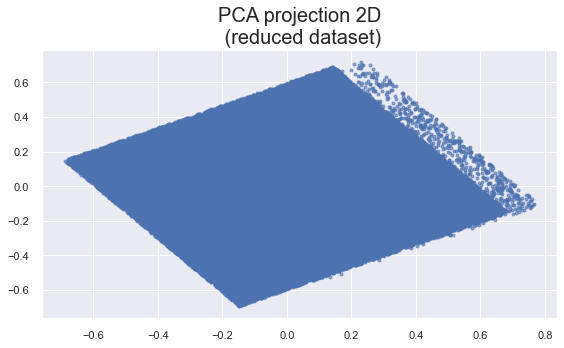

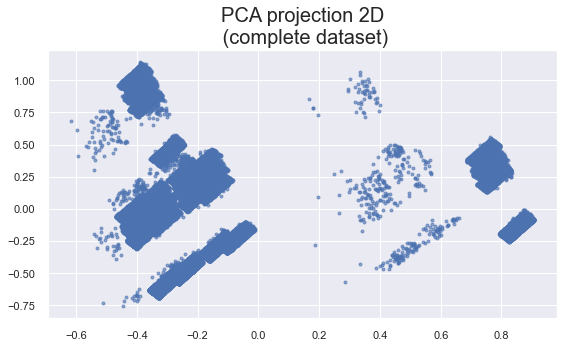

In [19]:
for key, value in DFs_REDUCED.items():
    plt.figure(figsize=(8,5))
    plt.title("PCA projection 2D\n (" + key.rsplit("_")[-1] + " dataset)", size=20)
    plt.scatter(value[:, 0], value[:, 1], alpha=0.6, marker='.')
    plt.tight_layout()
    plt.savefig("images/PCA-projection-2D-" + key + ".png")
    plt.show()
    

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>For now, It seems that there are more defined clusters for only RFM features in comparison with all features</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.2. Correlation matrix</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation matrix</b>
</div>

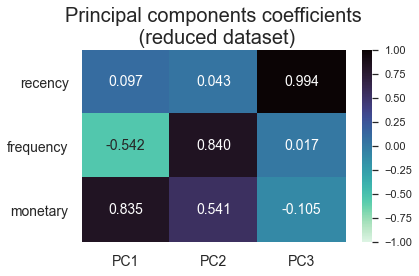

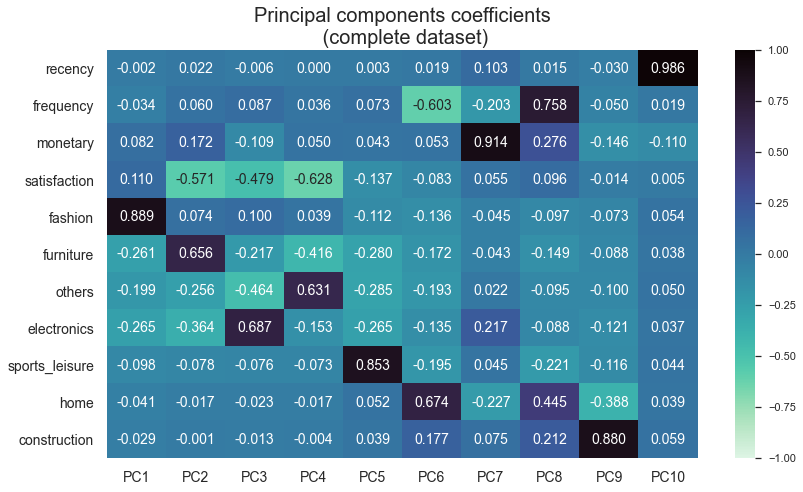

In [20]:
for key, value in DFs_ORIGINAL.items():
    
    if key == "reduced":
        plt.figure(figsize=(6,4))
    else:
        plt.figure(figsize=(12, 7))
        
    plt.title("Principal components coefficients\n (" + key + " dataset)", size=20)
    
    ax = sns.heatmap(globals()["df_pca_" + key], vmin=-1, vmax=1, center=0, cmap="mako_r",
                    annot=True, annot_kws={"size": 14}, fmt=".3f")

    plt.xticks(size=14)
    plt.yticks(rotation=0, size=14)
    plt.tight_layout()
    plt.savefig("images/principal-components-coefficients-" + key + ".png")
    plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Dataset reduced: </b>Monetary has a strong relation with PC1 and PC2. At the same time, Frequency has a positive relation with PC2 and inverse relation with PC1.<br>
            Finally, Recency has a strong relation with PC3</li>
        <li><b>Dataset complete: </b>We can see how category are distributed among the differents components. Recency has a strong relation with PC1 and PC2 has a strong relation with the product weight and volume</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.3. Scree of eigenvalues</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Scree of eigenvalues</b>
</div>

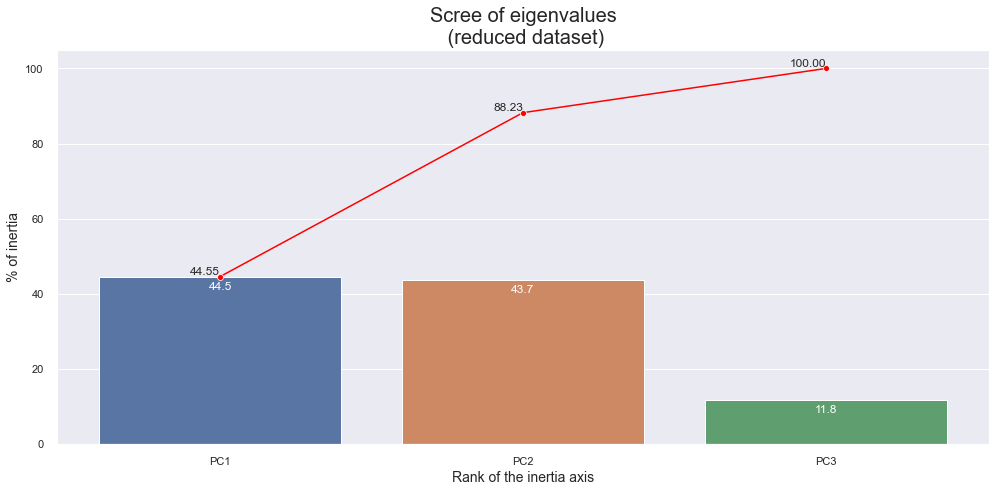

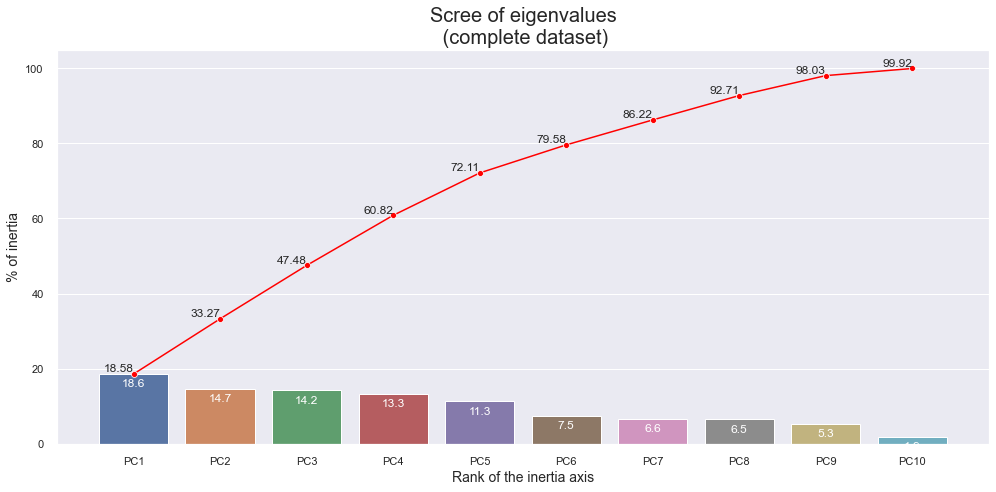

In [21]:
for key, value in DFs_ORIGINAL.items():
    
    scree = globals()["pca_" + key].explained_variance_ratio_*100

    fig = plt.subplots(figsize=(14, 7))
    plot_bar = sns.barplot(x=globals()["df_pca_" + key].columns, y=scree)
    for p in plot_bar.patches:
        plot_bar.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha="center", va="bottom", xytext=(0, -15), textcoords="offset points", color="white")
    plot_line = sns.lineplot(x=globals()["df_pca_" + key].columns, y=scree.cumsum(), marker="o", color="red")

    for x, y in zip(globals()["df_pca_" + key].columns, scree.cumsum()):
        plot_line.text(x, y, "{:.2f}".format(y), ha="right", va="bottom")

    plt.xlabel("Rank of the inertia axis", size=14)
    plt.ylabel("% of inertia", size=14)
    plt.title("Scree of eigenvalues\n (" + key + " dataset)", size=20)
    plt.tight_layout()
    plt.savefig("images/scree-of-eigenvalues-" + key + ".png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Dataset reduced: </b>PC2 has the 88.23% of the data variance. </li>
        <li><b>Dataset completed: </b>PC8 has the 92.71% of the data variance.</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.4. Correlation Circle</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b> for <b>dataset reduced</b>
</div>

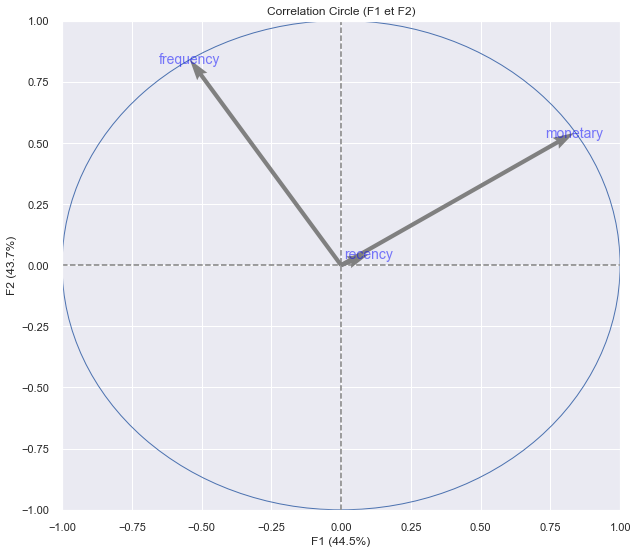

In [22]:
display_circles(pca_reduced.components_, n_comp_reduced, pca_reduced, [(0,1),(2,3),(4,5)], labels=np.array(features_reduced))

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Recency has not a strong influence in PC1 or PC2 unlike to Frequency and Monetary</p>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b> for <b>dataset completed</b>
</div>

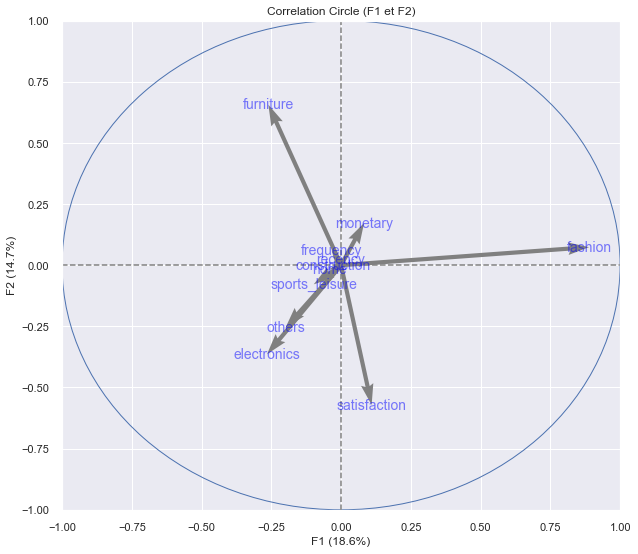

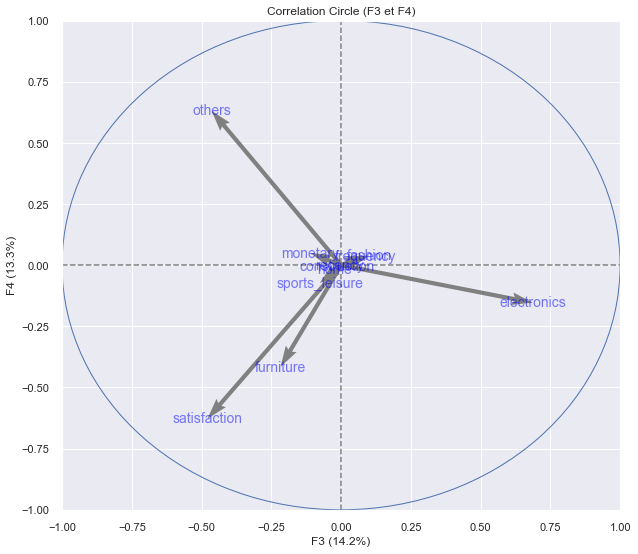

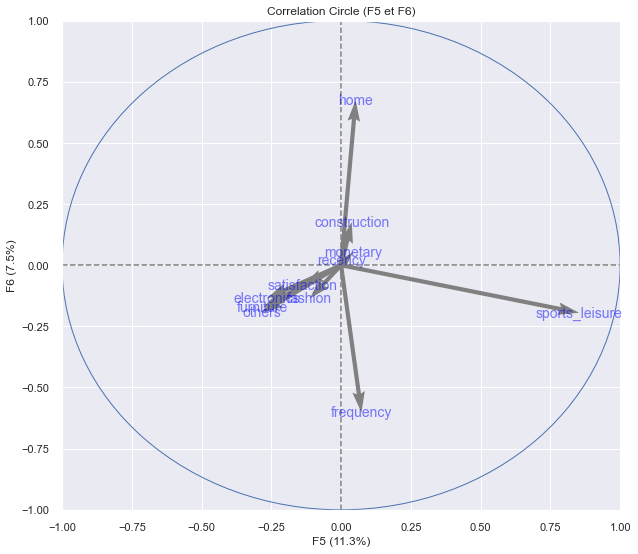

In [23]:
display_circles(pca_complete.components_, n_comp_complete, pca_complete, [(0,1),(2,3),(4,5)], labels=np.array(features_complete))

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.5. Projection of individuals</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Projection of individuals</b>
</div>

In [24]:
for key, value in DFs_ORIGINAL.items():
    
    globals()["X_projected_" + key] = globals()["pca_" + key].transform(globals()["X_" + key])
    globals()["index_values_sample_" + key] = pd.Series(globals()["index_values_" + key]).sample(10000)

<div class="alert alert-block alert-info">
    Plotting the Projection of individuals for <b>dataset reduced</b></b>
</div>

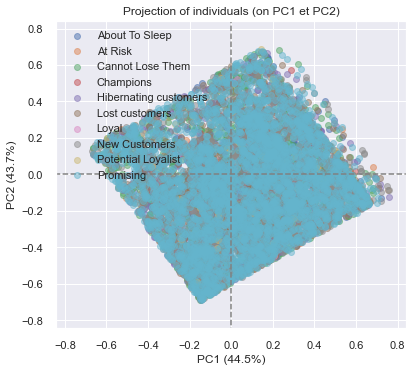

In [25]:
display_factorial_planes(X_projected_reduced, n_comp_reduced, pca_reduced, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample_reduced), 
                         illus_var=df_data.loc[index_values_sample_reduced, "rfm_score_label"], 
                         lab_on=False, alpha = 0.5)

<div class="alert alert-block alert-info">
    Plotting the Projection of individuals for <b>dataset completed</b></b>
</div>

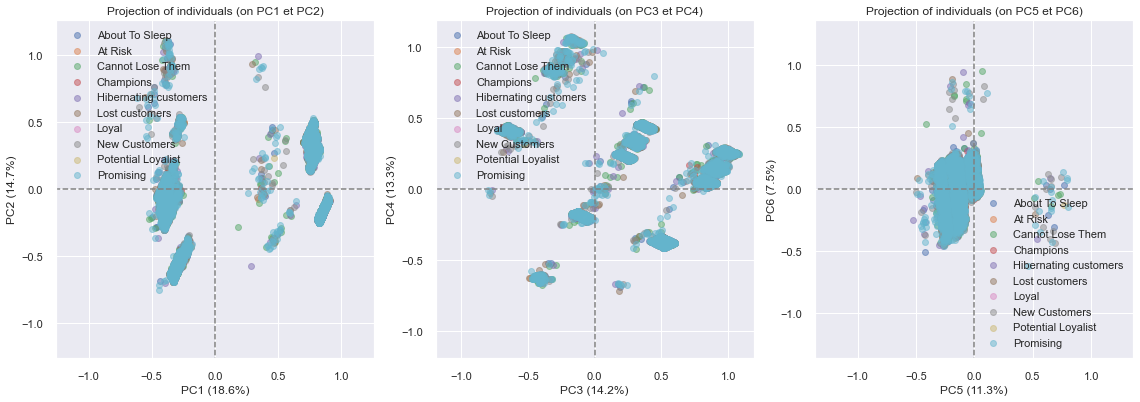

In [26]:
display_factorial_planes(X_projected_complete, n_comp_complete, pca_complete, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample_complete), 
                         illus_var=df_data.loc[index_values_sample_complete, "rfm_score_label"], 
                         lab_on=False, alpha=0.5)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.6. Variance of the components</h4>
</div>

<div class="alert alert-block alert-info">
    <p>For both dataset, we are going to keep the 85% of the variance</p>
</div>

In [27]:
var_threshold = 0.85

for key, value in DFs_ORIGINAL.items():
    
    print(key)
        
    # Processing the PCA
    globals()["pca_" + key] = decomposition.PCA()
    globals()["pca_" + key].fit(globals()["X_" + key])
    
    # Getting the explained variance ratio for each principal component
    globals()["scree_" + key] = globals()["pca_" + key].explained_variance_ratio_
    
    # Getting the number of principal components to reach variance thresholds
    globals()["mask_" + key] = globals()["scree_" + key].cumsum() > var_threshold
    globals()["nb_selected_components_" + key] = len(globals()["scree_" + key][~globals()["mask_" + key]]) + 1
    
    # Compute and displays the actual ratio of explained variance
    globals()["explained_variance_sum_" + key] = globals()["scree_" + key].cumsum()[globals()["nb_selected_components_" + key]-1]

    # Getting the projection of the data on the first components
    globals()["X_PCA_" + key] = globals()["pca_" + key].transform(globals()["X_" + key])[:,:globals()["nb_selected_components_" + key]]

    
    COL_TO_PC =  ["PC" + str(i + 1) for i in range(globals()["nb_selected_components_" + key])]
    globals()["df_pca_" + key] = pd.DataFrame(data=globals()["X_PCA_" + key], columns=COL_TO_PC, index=globals()["index_values_" + key])
    
    DFs_PCA["df_pca_" + key] = globals()["df_pca_" + key]
    
    print("-- Dataset " + key + " components --")
    print("Number of selected components:", globals()["nb_selected_components_" + key])
    print("Cumulative explained variance:  {:.2f}%".format(globals()["explained_variance_sum_" + key]*100))
    print("Shape: " + str(globals()["df_pca_" + key].shape))
    print("\n")


reduced
-- Dataset reduced components --
Number of selected components: 2
Cumulative explained variance:  88.23%
Shape: (66934, 2)


complete
-- Dataset complete components --
Number of selected components: 7
Cumulative explained variance:  86.22%
Shape: (66934, 7)




<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Dataset reduced: </b>We got 88.23% of the variance and 2 Components. </li>
        <li><b>Dataset completed: </b>we got 86.22% of the variance and 7 components</li>
    </ul> 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Datasets to works</h2>
</div>

<div class="alert alert-block alert-info">
    <p>As you can notice, we are working with 2 datasets </p>
    <ul style="list-style-type: disc;">
        <li><b>Reduced dataset</b>: PCA only 3 features (RFM)</li>
        <li><b>Completed dataset</b>: PCA all features</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. PCA Reduced dataset</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the RFM segmentation<br>
    Below, the used features to do the PCA
    </p>
    <ul style="list-style-type: disc;">
        <li>recency</li>
        <li>frequency</li>
        <li>monetary</li>
    </ul> 
</div>

In [28]:
df_pca_reduced

PC1       PC2
0     -0.080201 -0.645925
1      0.089005 -0.535138
2     -0.148869 -0.681458
3      0.596293 -0.190470
4      0.369414 -0.337419
...         ...       ...
66929 -0.396433  0.302956
66930 -0.484030  0.264107
66931  0.394182  0.164551
66932  0.390904  0.229801
66933 -0.075348  0.286741

[66934 rows x 2 columns]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.2. PCA Complete dataset</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Based on the RFM segmentation and the most purchased categories<br>
    Below, the used features to do the PCA
    </p>
    <ul style="list-style-type: disc;">
        <li>recency</li>
        <li>frequency</li>
        <li>monetary</li>
        <li>satisfaction</li>
        <li>fashion</li>
        <li>furniture</li>
        <li>others</li>
        <li>electronics</li>
        <li>sports_leisure</li>
        <li>home</li>
        <li>construction</li>
    </ul> 
</div>

In [29]:
df_pca_complete 

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0     -0.255560 -0.570982 -0.639994  0.372441 -0.335596  0.135766 -0.256297
1     -0.238842 -0.535919 -0.662118  0.382560 -0.326798  0.146007 -0.070717
2     -0.262189 -0.583850 -0.630890  0.368876 -0.338367  0.127116 -0.328522
3     -0.188513 -0.428990 -0.728277  0.413617 -0.299360  0.170738  0.489762
4     -0.210903 -0.475773 -0.698592  0.400141 -0.311021  0.156245  0.241452
...         ...       ...       ...       ...       ...       ...       ...
66929 -0.166280 -0.291987 -0.195438 -0.284564  0.883810 -0.435668 -0.201017
66930 -0.174629 -0.307466 -0.183737 -0.288739  0.880823 -0.449790 -0.291029
66931 -0.309998  0.170853 -0.216500  1.057330 -0.131666  0.009324  0.372514
66932 -0.273065 -0.008532 -0.373107  0.853942 -0.171283 -0.050427  0.409203
66933 -0.239704 -0.435713 -0.628213  0.426148 -0.256589 -0.307040  0.053476

[66934 rows x 7 columns]

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. K-Means - (PCA reduced)</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Let's see in details the cluster for the reduced dataset after doing the PCA</p>
    
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Number of Cluster</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to use <b>internal information</b> to identify the the number of cluster. To do that, we are going to use the following metrics:</p>
    <ul style="list-style-type: disc;">
        <li><b>Within-Cluser-Sum of Squared Errors</b></li>
        <li><b>Davies-Bouldin score</b></li>
        <li><b>Silhouette score</b></li>
    </ul> 
</div>

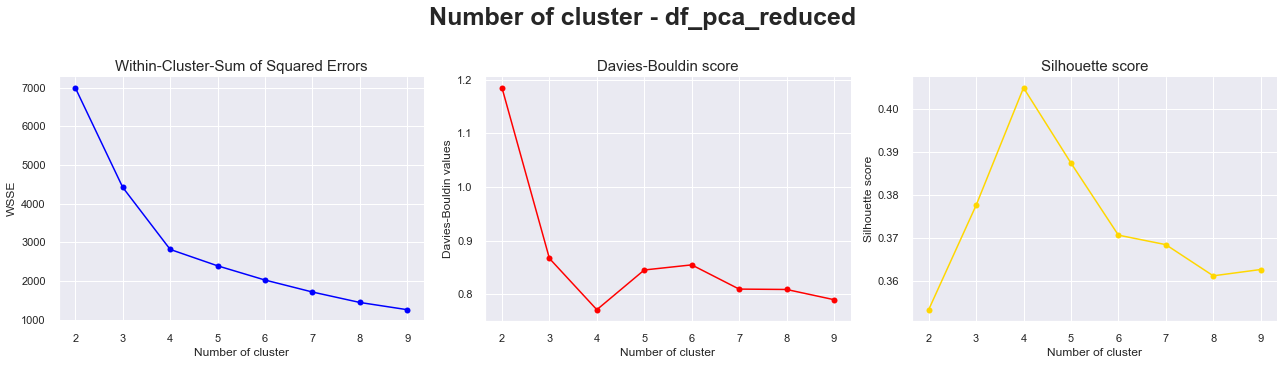

In [30]:
number_of_cluster(df_pca_reduced, "df_pca_reduced")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li>For <b>Reduced dataset</b>, we can see how the three metrics have given similar results in 4 clusters.</li>
    </ul> 
    <p>For now, we are going to work with <b>Silhouette score</b> because it is the most informative, and we are going to work with the number of cluster higher or close to 1</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Silhouette analysis</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's go deeper into the Silhoutte analysis</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.3533760653639853
For n_clusters = 3 The average silhouette_score is : 0.3775909101191365
For n_clusters = 4 The average silhouette_score is : 0.4048688472236305
For n_clusters = 5 The average silhouette_score is : 0.38740848679971046
For n_clusters = 6 The average silhouette_score is : 0.3706773078028246
For n_clusters = 7 The average silhouette_score is : 0.36847248890625933
For n_clusters = 8 The average silhouette_score is : 0.36123850019901066
For n_clusters = 9 The average silhouette_score is : 0.36270219862111897


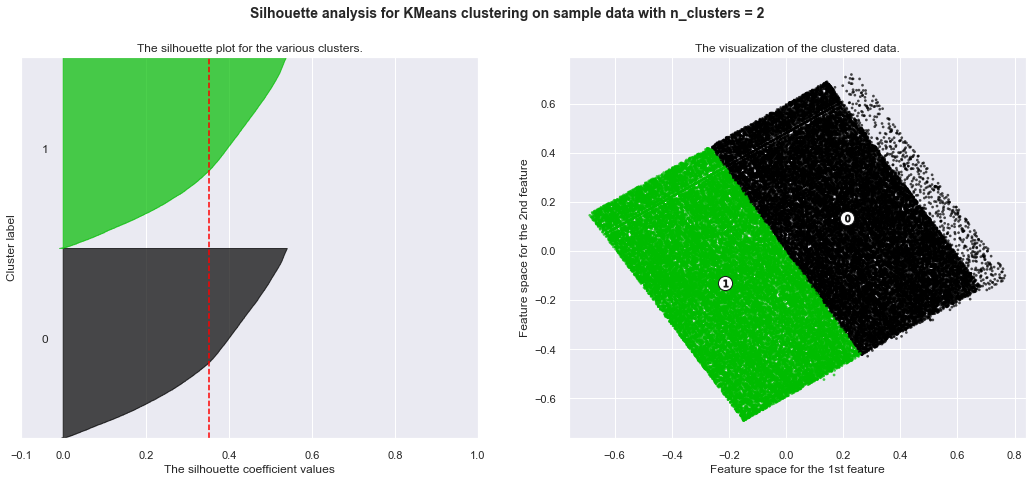

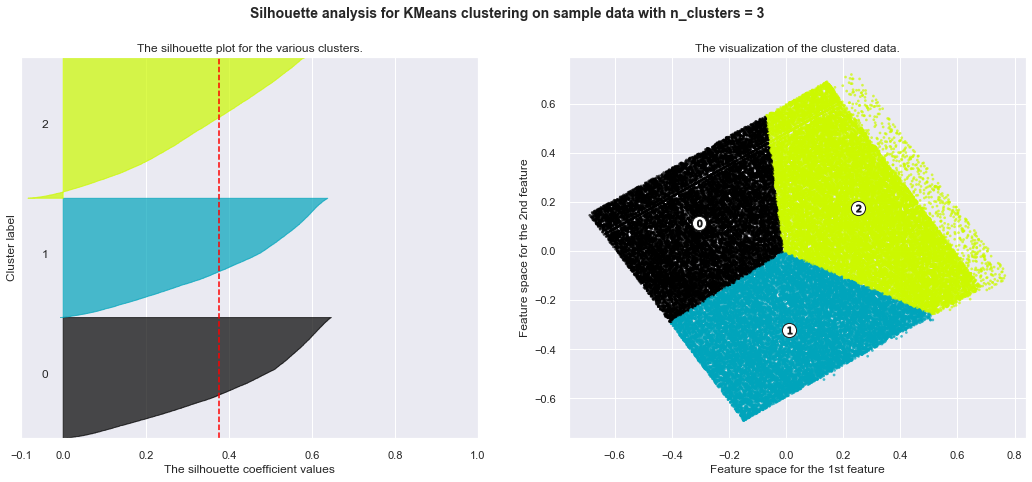

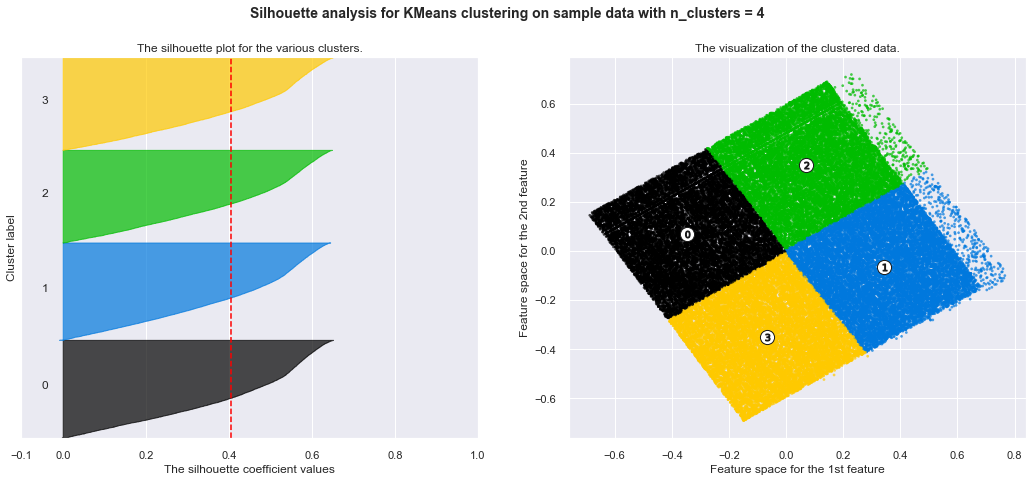

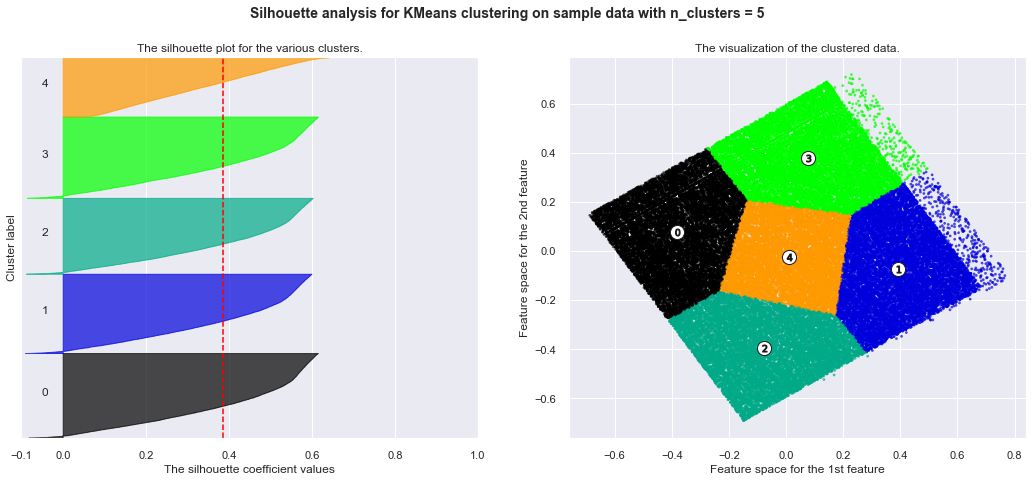

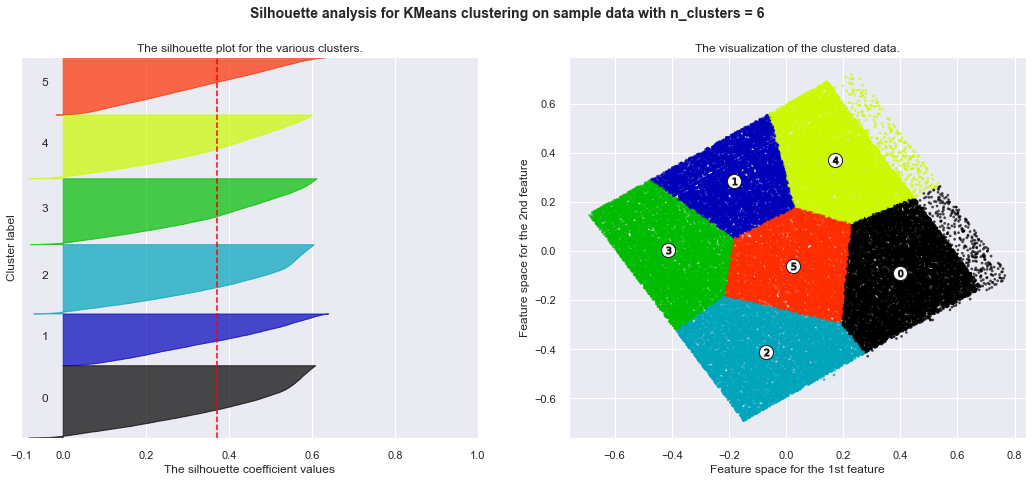

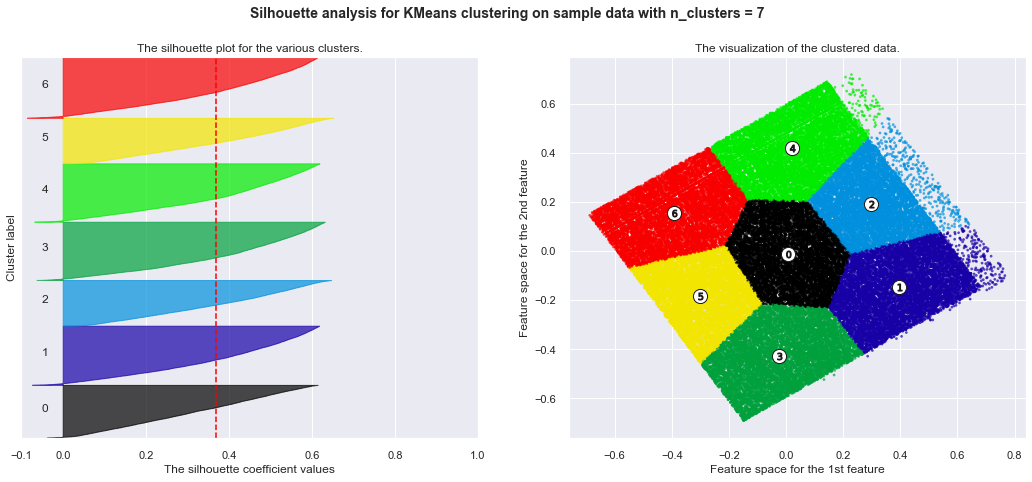

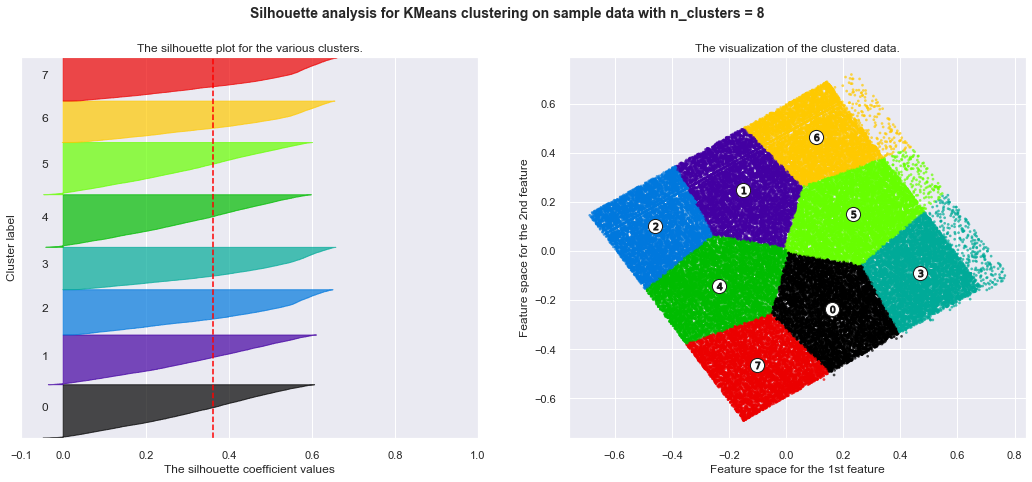

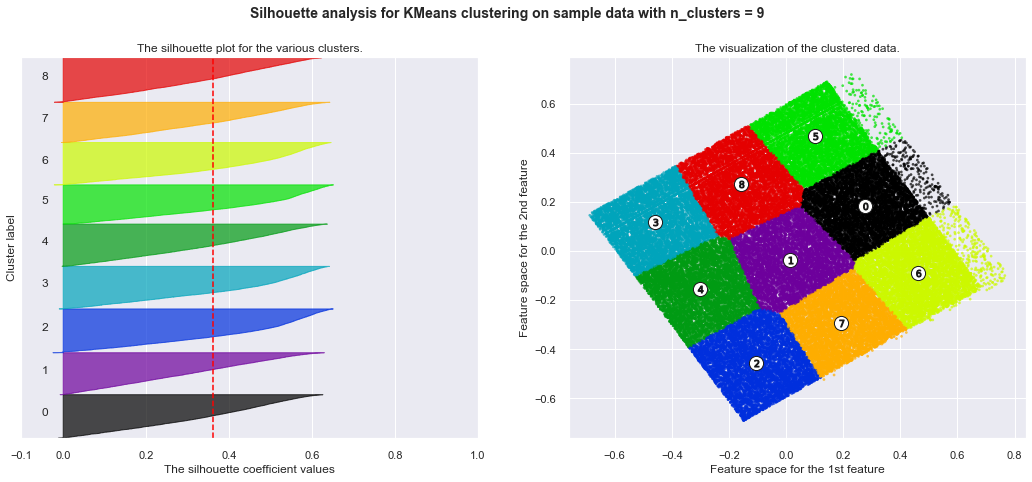

In [31]:
silhoutte_analysis(df_pca_reduced.values)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>PCA reduced</b> The best score is for n_clusters = 4 The average silhouette_score is : 0.40</li>
    </ul> 
    <p>We also obtain that the reduced PCA dataset has clear clusters.</p>
    <p>So, from now on, we are going to use this setup.</p>
</div>

In [32]:
kmeans = KMeans(init="k-means++", n_clusters=4, max_iter=1000, random_state=10)

cluster_labels = kmeans.fit_predict(df_pca_reduced)
centroids = kmeans.cluster_centers_

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3. Clusters in PCA</h3>
</div>

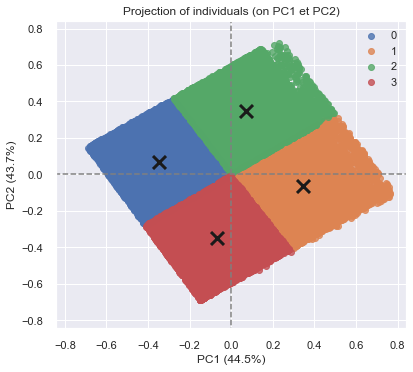

In [33]:
display_factorial_planes(X_projected_reduced, n_comp_reduced, pca_reduced, [(0,1),(2,3),(4,5)], 
                         illus_var=cluster_labels, lab_on=False, alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, 
            linewidths=3, color="k", zorder=10)

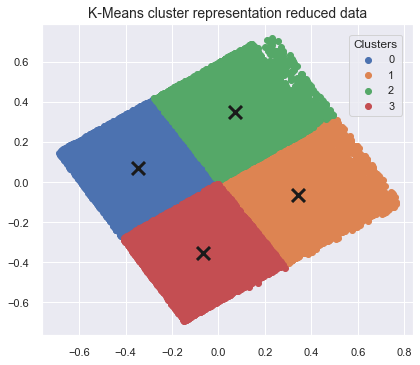

In [34]:
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(6, 5))
for i in unique_labels:
    plt.scatter(df_pca_reduced.values[cluster_labels==i, 0], df_pca_reduced.values[cluster_labels==i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, 
            linewidths=3, color="k", zorder=10)
plt.legend(loc="best", borderaxespad=1, title="Clusters", frameon=True, fancybox=True)
plt.tight_layout()
plt.title("K-Means cluster representation reduced data", size=14)
plt.savefig("images/kmeans-cluster-representation-pca-reduced.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Meaning of the Clusters</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's interpreting the meaning of each cluster based on the Parallel Coordinates Plot.</p>
</div>

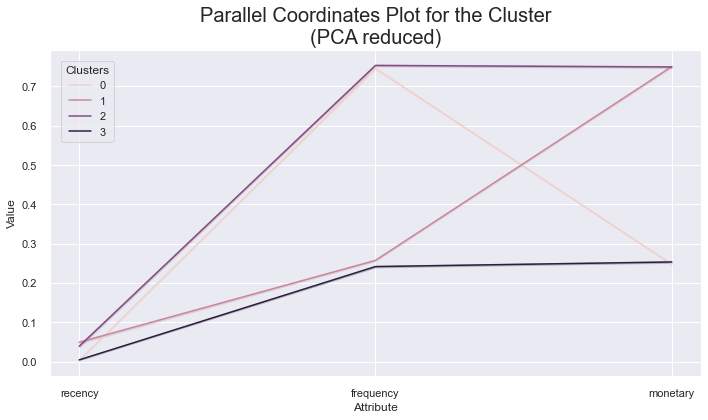

In [35]:
df_sample_scaled_reduced["ID"] = data_reduced.index
df_sample_scaled_reduced["Cluster"] = kmeans.labels_

df_reduced_melt = pd.melt(df_sample_scaled_reduced.reset_index(),
                          id_vars=["ID", "Cluster"],
                          value_vars=["recency", "frequency", "monetary"],
                          var_name="Attribute",
                          value_name="Value")

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title("Parallel Coordinates Plot for the Cluster\n(PCA reduced)", size=20)
sns.lineplot(x="Attribute", y="Value", hue="Cluster", data=df_reduced_melt, ax=ax1)
plt.legend(loc="best", borderaxespad=1, title="Clusters", frameon=True, fancybox=True)
plt.tight_layout()
plt.savefig("images/parallel-coordinates-plot-pca-reduced.png")
plt.show()
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Based on the plot, we can say the following</p>
    <ul style="list-style-type: disc;">
        <li><b>Cluster 0</b> Customer who bought recently, more than once and for a low amount of money.</li>
        <li><b>Cluster 1</b> Customer who bought recently, only once and for a good amount of money.</li>
        <li><b>Cluster 2</b> Customer who bought recently, more than once and for a good amount of money.</li>
        <li><b>Cluster 3</b> Customer who bought recently, only once and for a low amount of money.</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.5. Intercluster Distance Maps</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to use the best score to plot the intercluster distance</p>
</div>

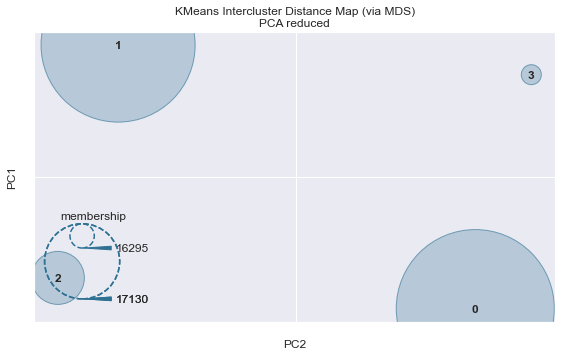

C:\Users\Samir\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)\nPCA reduced'}, xlabel='PC2', ylabel='PC1'>,
                     model=None)

In [36]:
intercluster_distance(kmeans, df_pca_reduced.values, size=(672, 384), 
                      title="KMeans Intercluster Distance Map (via MDS)\nPCA reduced")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The clusters seem clear separeted</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. K-Means - (PCA complete)</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Let's see in details the cluster for the dataset complete after doing the PCA</p>
    
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Number of Cluster</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to use <b>internal information</b> to identify the the number of cluster. To do that, we are going to use the following metrics:</p>
    <ul style="list-style-type: disc;">
        <li><b>Within-Cluser-Sum of Squared Errors</b></li>
        <li><b>Davies-Bouldin score</b></li>
        <li><b>Silhouette score</b></li>
    </ul> 
</div>

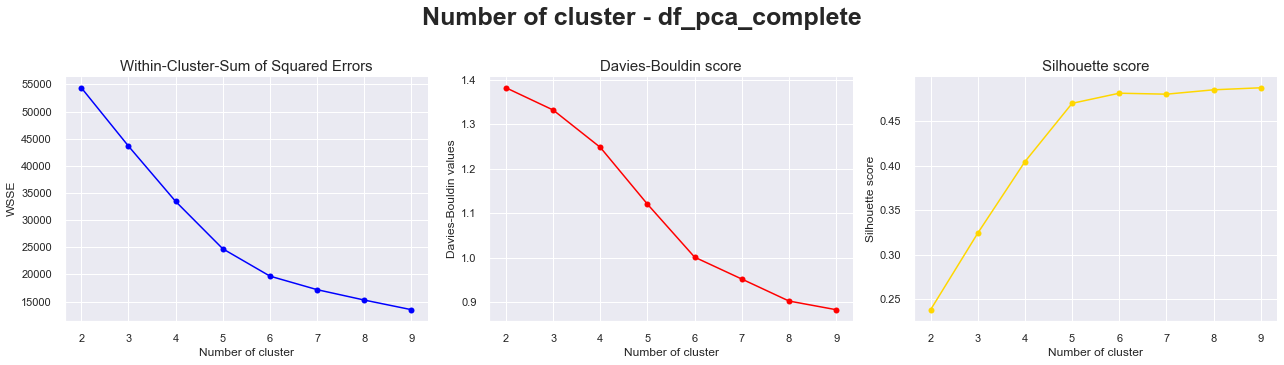

In [37]:
number_of_cluster(df_pca_complete, "df_pca_complete")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li>For <b>dataset complete</b>, it is not clear the number of cluster. We can guess a number of cluster between 5 and 9.</li>
    </ul> 
    <p>For now, we are going to work with <b>Silhouette score</b> because it is the most informative, and we are going to work with the number of cluster higher or close to 1</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Silhouette analysis</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's go deeper into the Silhoutte analysis</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.23821316808045237
For n_clusters = 3 The average silhouette_score is : 0.3242120580641545
For n_clusters = 4 The average silhouette_score is : 0.40446769010140704
For n_clusters = 5 The average silhouette_score is : 0.4699655146334349
For n_clusters = 6 The average silhouette_score is : 0.48132566373457075
For n_clusters = 7 The average silhouette_score is : 0.4802277221041931
For n_clusters = 8 The average silhouette_score is : 0.48514502502000645
For n_clusters = 9 The average silhouette_score is : 0.48741913470774667


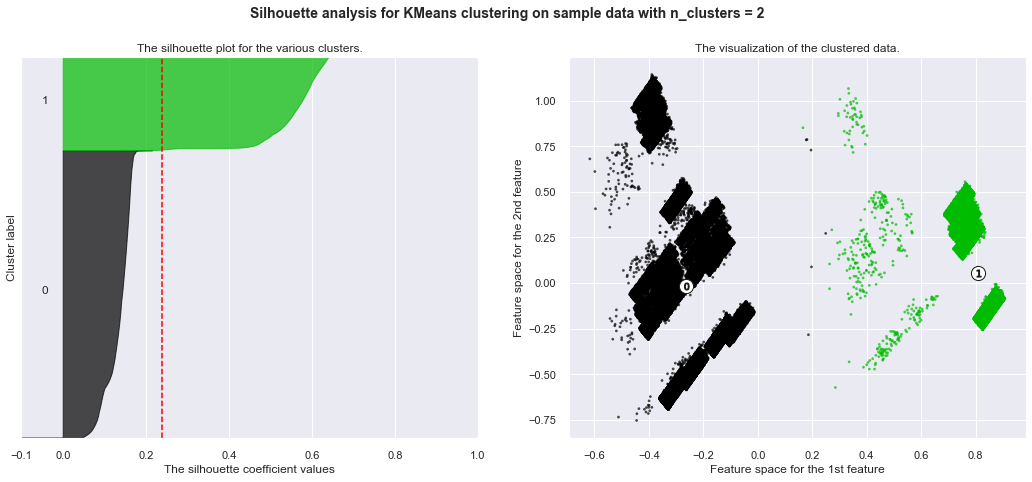

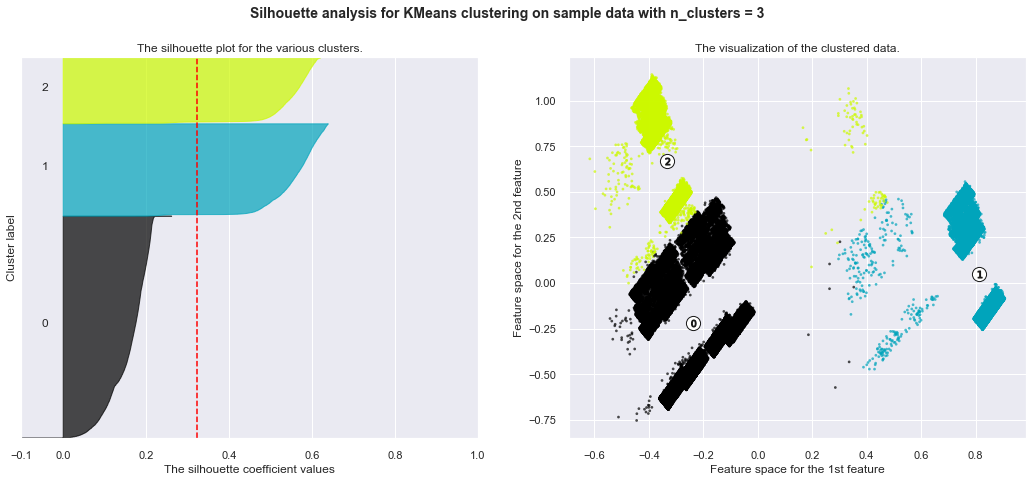

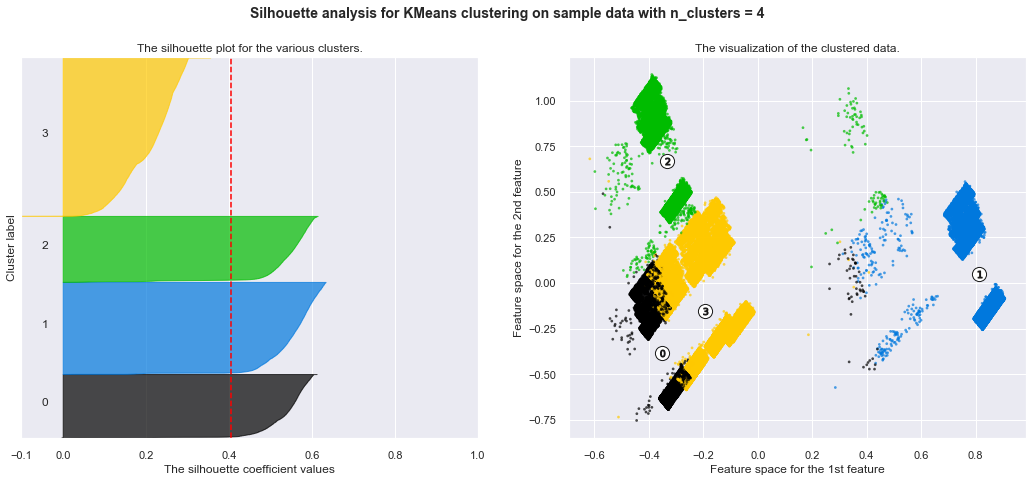

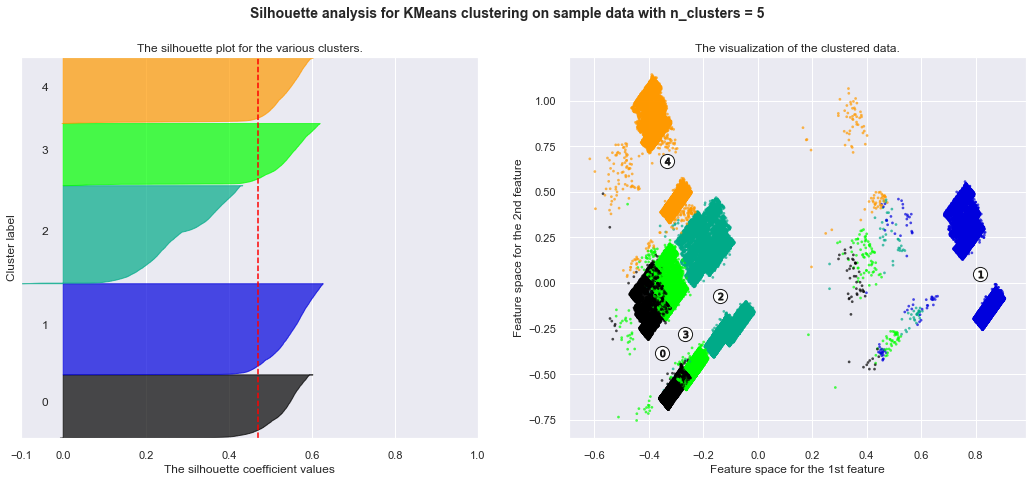

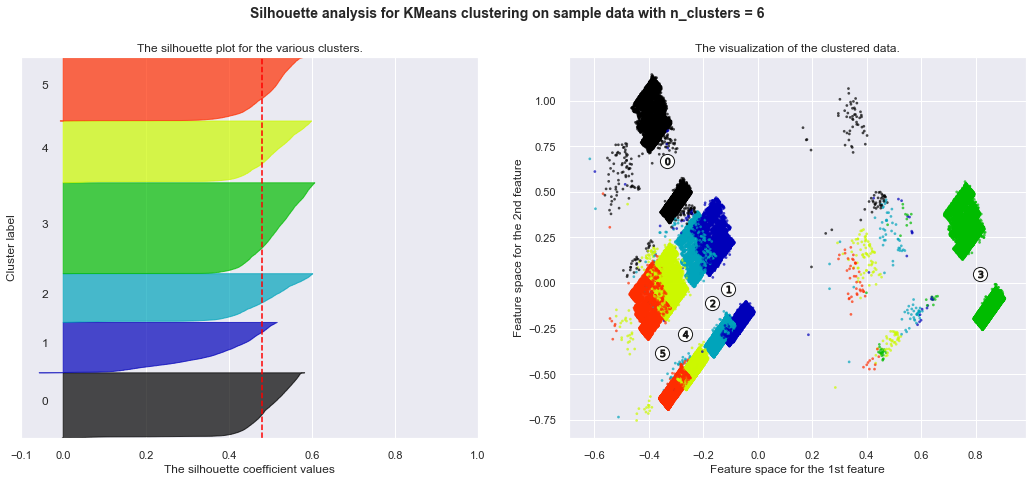

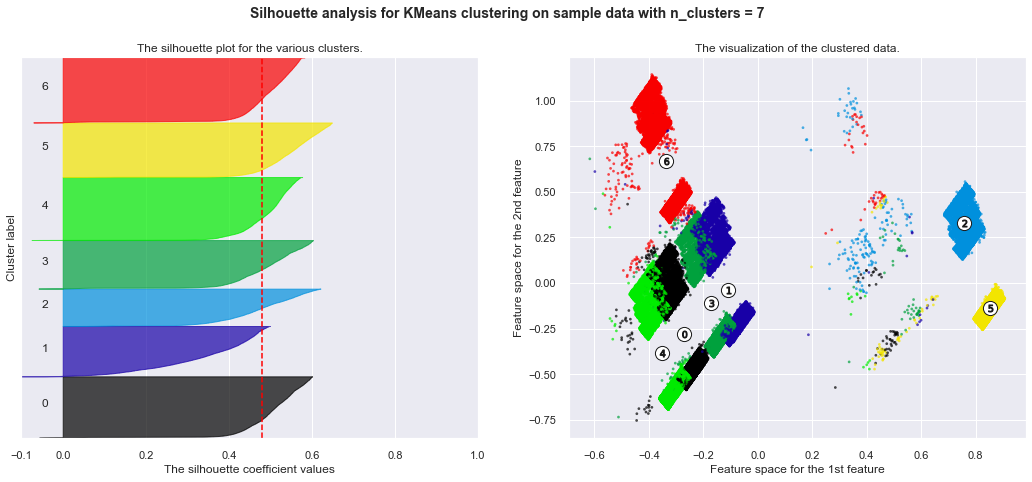

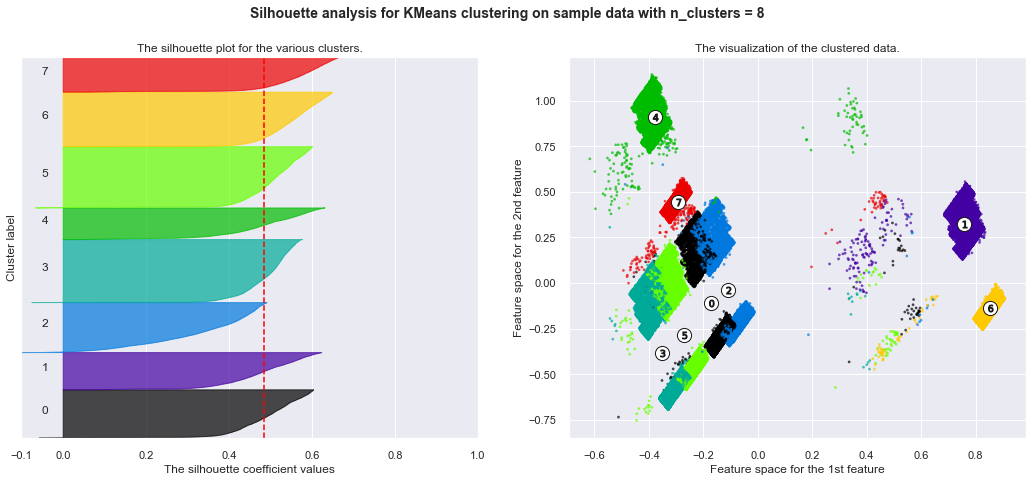

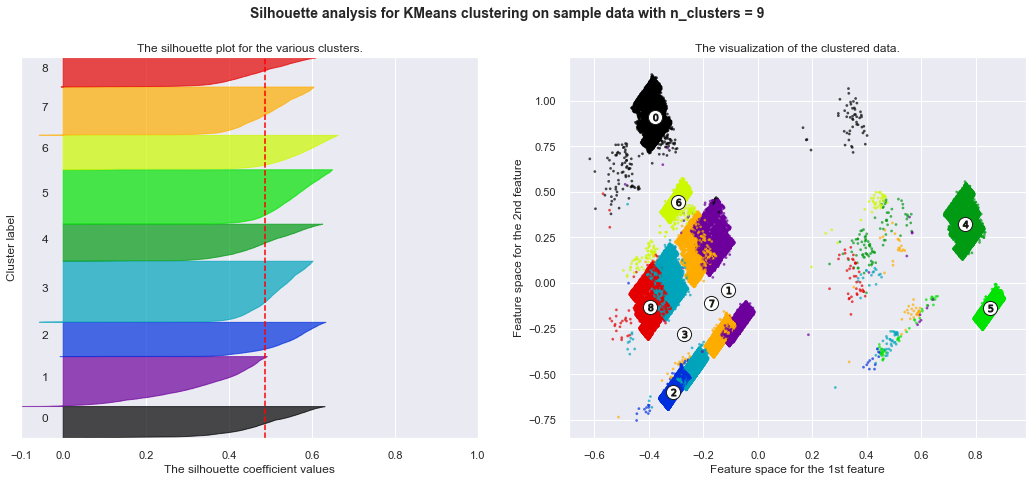

In [38]:
silhoutte_analysis(df_pca_complete.values)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>PCA complete</b> The best score is for n_clusters = 9 The average silhouette_score is : 0.48</li>
    </ul> 
    <p>But, the results are very similar between 5 and 9 clusters.</p>
    <p>So, from now on, we are going to use this setup.</p>
</div>

In [39]:
kmeans = KMeans(init="k-means++", n_clusters=9, max_iter=1000, random_state=10)

cluster_labels = kmeans.fit_predict(df_pca_complete)
centroids = kmeans.cluster_centers_

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Clusters in PCA</h3>
</div>

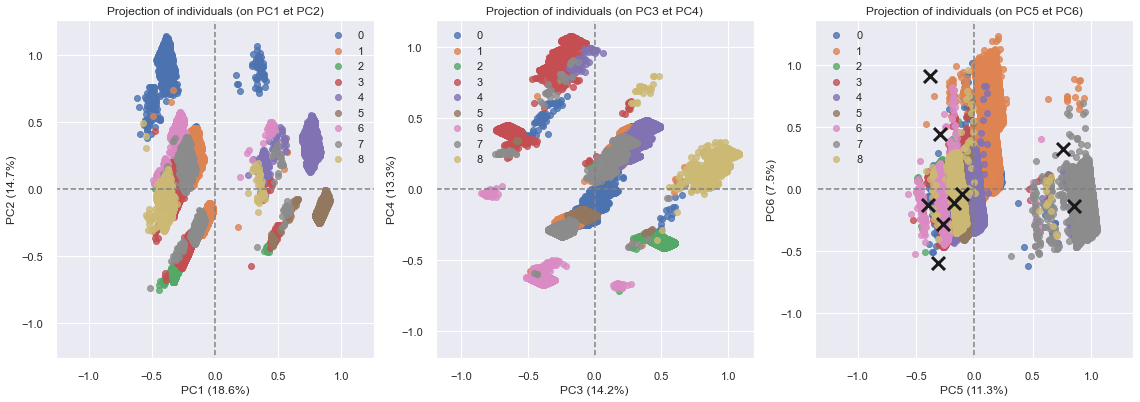

In [40]:
display_factorial_planes(X_projected_complete, n_comp_complete, pca_complete, [(0,1),(2,3),(4,5)], 
                         illus_var=cluster_labels, lab_on=False, alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, 
            linewidths=3, color="k", zorder=10)

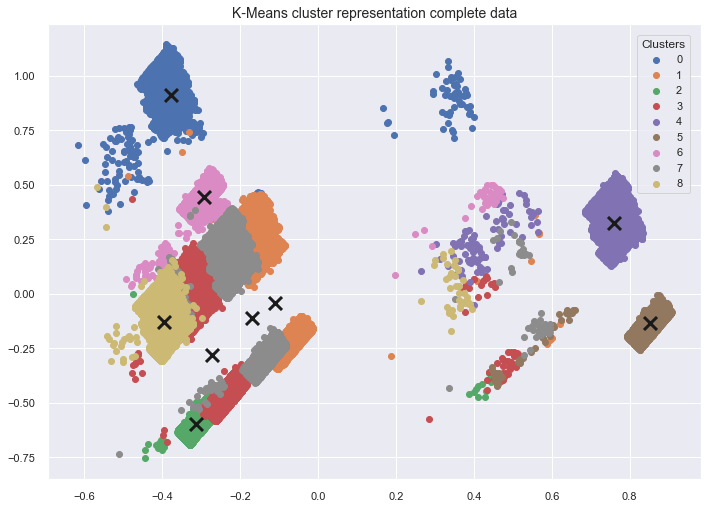

In [41]:
unique_labels = np.unique(cluster_labels)

plt.figure(figsize=(10, 7))
for i in unique_labels:
    plt.scatter(df_pca_complete.values[cluster_labels==i, 0], df_pca_complete.values[cluster_labels==i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, 
            linewidths=3, color="k", zorder=10)
plt.legend(loc="best", borderaxespad=1, title="Clusters", frameon=True, fancybox=True)
plt.tight_layout()
plt.title("K-Means cluster representation complete data", size=14)
plt.savefig("images/kmeans-cluster-representation-pca-complete.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.4. Meaning of the Clusters</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's interpreting the meaning of each cluster based on the Parallel Coordinates Plot.</p>
</div>

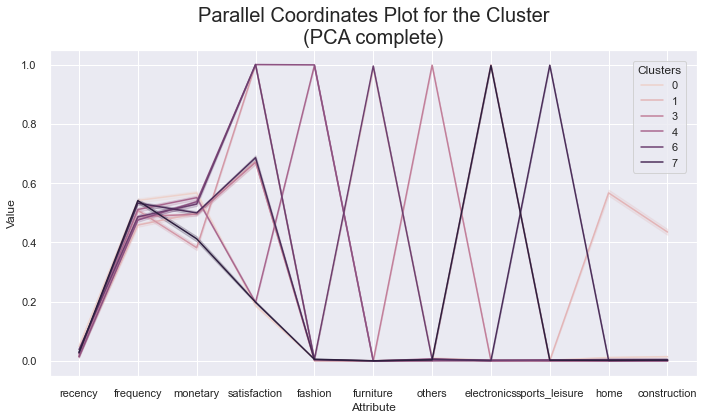

In [42]:
df_sample_scaled_complete["ID"] = data_complete.index
df_sample_scaled_complete["Cluster"] = kmeans.labels_

df_complete_melt = pd.melt(df_sample_scaled_complete.reset_index(),
                          id_vars=["ID", "Cluster"],
                          value_vars=["recency", "frequency", "monetary", "satisfaction", "fashion",
                                     "furniture", "others", "electronics", "sports_leisure", "home", 
                                     "construction"],
                          var_name="Attribute",
                          value_name="Value")

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title("Parallel Coordinates Plot for the Cluster\n(PCA complete)", size=20)
sns.lineplot(x="Attribute", y="Value", hue="Cluster", data=df_complete_melt, ax=ax1)
plt.legend(loc="best", borderaxespad=1, title="Clusters", frameon=True, fancybox=True)
plt.tight_layout()
plt.savefig("images/parallel-coordinates-plot-pca-complete.png")
plt.show()
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Here, we can see customer who bought more than one category but, this graph is not totally clear.</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.5. Intercluster Distance Maps</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to use the best score to plot the intercluster distance</p>
</div>

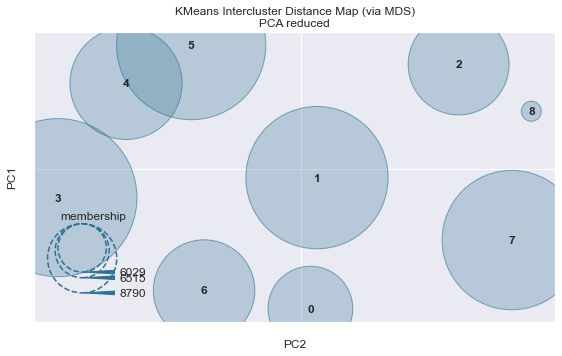

C:\Users\Samir\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)\nPCA reduced'}, xlabel='PC2', ylabel='PC1'>,
                     model=None)

In [43]:
intercluster_distance(KMeans(init="k-means++", n_clusters=9, n_init=4, max_iter=1000, random_state=10),
                      df_pca_complete.values, size=(672, 384), 
                      title="KMeans Intercluster Distance Map (via MDS)\nPCA reduced")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The clusters do not seem clear separeted</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Selecting the model</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyze the two models through <b>external information</b> and <b>internal information</b> to select the best model.<br>
        To do that, we are going to use the following <b>Cluster quality metrics</b>:</p>
    <ul style="list-style-type: disc;">
        <li><b>homo</b>: homogeneity score</li>
        <li><b>compl</b>: completeness score</li>
        <li><b>v-meas</b>: V measure</li>
        <li><b>ARI</b>: adjusted Rand index</li>
        <li><b>AMI</b>: adjusted mutual information</li>
        <li><b>silhouette</b>: silhouette coefficient</li>
    </ul> 
    <p>To analyze the model based on <b>external information</b>, we are going to use the <b>RFM segmentation done earlier</b> to compare the resulting clusters<br>
       So, we start by transforming the RFM Segmentation with OrdinalEncoder</p>
</div>

In [44]:
oe = OrdinalEncoder(categories=[["Champions", "Loyal", "Potential Loyalist", "New Customers",
                           "Promising", "About To Sleep", "At Risk", "Cannot Lose Them",
                           "Hibernating customers", "Lost customers"]])

In [45]:
df_sample_scaled_reduced["rfm_label"] = oe.fit_transform(df_data[["rfm_score_label"]])
df_sample_scaled_complete["rfm_label"] = oe.fit_transform(df_data[["rfm_score_label"]])

In [46]:
df_sample_scaled_reduced.head(3)

recency  frequency  monetary  ID  Cluster  rfm_label
0      0.0   0.001001  0.082583   0        3        3.0
1      0.0   0.002002  0.285953   1        3        3.0
2      0.0   0.008509  0.005189   2        3        3.0

In [47]:
df_sample_scaled_complete.head(3)

recency  frequency  monetary  satisfaction  fashion  furniture  others  \
0      0.0   0.001001  0.082583           1.0      0.0        0.0     1.0   
1      0.0   0.002002  0.285953           1.0      0.0        0.0     1.0   
2      0.0   0.008509  0.005189           1.0      0.0        0.0     1.0   

   electronics  sports_leisure  home  construction  ID  Cluster  rfm_label  
0          0.0             0.0   0.0           0.0   0        3        3.0  
1          0.0             0.0   0.0           0.0   1        3        3.0  
2          0.0             0.0   0.0           0.0   2        3        3.0

<div class="alert alert-block alert-info">
    <p>Let's analyze the two models</p>
</div>

In [48]:
print(115 * '_')
print("{:<15} {:<10} {:<10} {:<10} {:<15}"
      "{:<11} {:<10} {:<10} {:<10} {:<10}".format("dataset", "clusters", "time",
                                                  "inertia", "silhouette", "homo",
                                                  "compl", "tv-meas", "ARI", "AMI"))

kmeans = KMeans(init="k-means++", n_clusters=4, max_iter=1000, random_state=10)
benchmark_kmeans("PCA-reduced", kmeans, n_clusters=4, data=df_pca_reduced.values, labels_true=df_sample_scaled_reduced["rfm_label"])

kmeans = KMeans(init="k-means++", n_clusters=9, max_iter=1000, random_state=10)
benchmark_kmeans("PCA-complete", kmeans, n_clusters=9, data=df_pca_complete.values, labels_true=df_sample_scaled_complete["rfm_label"])

___________________________________________________________________________________________________________________
dataset         clusters   time       inertia    silhouette     homo        compl      tv-meas    ARI        AMI       
PCA-reduced     4          0.687s       2814        0.405        0.495       0.614      0.548      0.480      0.548
PCA-complete    9          1.063s      13508        0.487        0.013       0.010      0.011      0.008      0.011


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>All the scores are better for PCA-reduced except the silhouette score</p>
    <p>So, we will continue with the PCA-reduced</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Plotting of Cluster with Spider plot</h3>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to add the cluster into the datasets initial to plot each cluster through a spider plot</p>
</div>

In [49]:
kmeans = KMeans(init="k-means++", n_clusters=4, max_iter=1000, random_state=10)
cluster_labels = kmeans.fit_predict(df_pca_reduced)
data_reduced["cluster"] = cluster_labels

In [50]:
data_reduced.head(3)

recency  frequency  monetary  cluster
0        6      False     37.46        3
1        7      False     67.58        3
2       11      False     20.38        3

In [51]:
rfm_sns_palette = sns.color_palette("husl", data_reduced["cluster"].nunique())
rfm_colors = {label : color for label, color in zip(data_reduced["cluster"].unique(), rfm_sns_palette.as_hex())}

In [53]:
CLUSTER_CATEGORIES = {
    0 : "Cluster 0",
    1 : "Cluster 1",
    2 : "CLuster 2",
    3 : "Cluster 3"
}

In [54]:
data_reduced["cluster_label"] = data_reduced["cluster"]

In [55]:
data_reduced["cluster_label"] = data_reduced["cluster_label"].replace(CLUSTER_CATEGORIES)

In [56]:
data_reduced.head()

recency  frequency  monetary  cluster cluster_label
0        6      False     37.46        3     Cluster 3
1        7      False     67.58        3     Cluster 3
2       11      False     20.38        3     Cluster 3
3       13      False    292.63        1     Cluster 1
4       13      False    138.95        1     Cluster 1

In [57]:
rfm_sns_palette = sns.color_palette("husl", data_reduced["cluster_label"].nunique())
rfm_colors = {label : color for label, color in zip(data_reduced["cluster_label"].unique(), rfm_sns_palette.as_hex())}

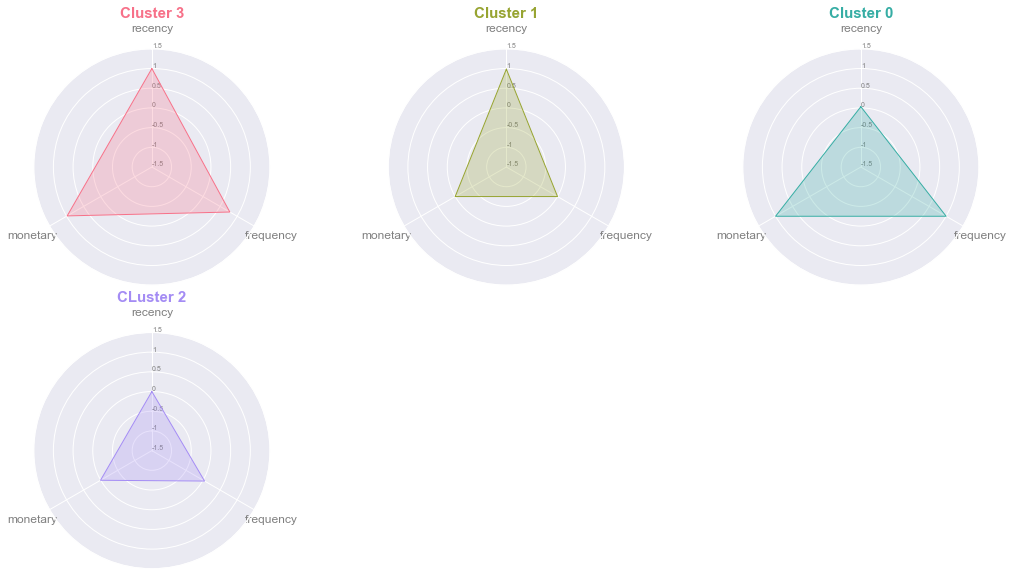

In [58]:
df_spider_RFM(data_reduced[["recency", "frequency", "monetary", "cluster_label"]], "cluster_label", rfm_colors)

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Based on the initial RFM segmentation, we can see the following:</p>
    <ul style="list-style-type: disc;">
        <li><b>Cluster 0</b> are <b>Champions</b> customers</li>
        <li><b>Cluster 1</b> are customer <b>About to Sleep</b></li>
        <li><b>Cluster 2</b> are the <b>Loyal Customers</b></li>
        <li><b>Cluster 3</b> are the <b>New Customers</b></li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

In [59]:
print(115 * '_')
print("{:<15} {:<10} {:<10} {:<10} {:<15}"
      "{:<11} {:<10} {:<10} {:<10} {:<10}".format("dataset", "clusters", "time",
                                                  "inertia", "silhouette", "homo",
                                                  "compl", "tv-meas", "ARI", "AMI"))
for i in range(2,10):
    kmeans = KMeans(init="k-means++", n_clusters=i, max_iter=1000, random_state=10)
    benchmark_kmeans("PCA-reduced", kmeans, n_clusters=i, data=df_pca_reduced.values, labels_true=df_sample_scaled_reduced["rfm_label"])

# kmeans = KMeans(init="k-means++", n_clusters=9, max_iter=1000, random_state=10)
# benchmark_kmeans("PCA-complete", kmeans, n_clusters=9, data=df_pca_complete.values, labels_true=df_sample_scaled_complete["rfm_label"])

___________________________________________________________________________________________________________________
dataset         clusters   time       inertia    silhouette     homo        compl      tv-meas    ARI        AMI       
PCA-reduced     2          0.359s       6996        0.353        0.246       0.610      0.350      0.260      0.350
PCA-reduced     3          0.506s       4420        0.378        0.332       0.521      0.406      0.281      0.406
PCA-reduced     4          0.63s       2814        0.405        0.495       0.614      0.548      0.480      0.548
PCA-reduced     5          1.211s       2389        0.387        0.559       0.601      0.579      0.483      0.579
PCA-reduced     6          1.29s       2021        0.371        0.559       0.538      0.548      0.421      0.548
PCA-reduced     7          1.602s       1711        0.368        0.599       0.531      0.563      0.406      0.563
PCA-reduced     8          2.129s       1441        0.361        0.636

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [60]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">REFERENCES</h2>
</div>

1. Silhouette Analysis vs Elbow Method vs Davies-Bouldin Index: Selecting the optimal number of clusters for KMeans clustering<br>
   https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/<br>

2. Selecting the number of clusters with silhouette analysis on KMeans clustering<br>
   https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py<br>

3. Clustering metrics better than the elbow-method<br>
   https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6<br>
    
4. A demo of K-Means clustering on the handwritten digits data<br>
   https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#a-demo-of-k-means-clustering-on-the-handwritten-digits-data<br>

https://www.definitions-marketing.com/definition/segmentation-rfm/<br>
https://lms.simplilearn.com/courses/4414/Introduction-to-Supervised-&-Unsupervised-Machine-Learning/syllabus<br>

https://classroom.udacity.com/courses/st101<br>
https://classroom.udacity.com/courses/ud827<br>
https://www.freecodecamp.org/news/free-machine-learning-course-10-hourse/<br>

https://towardsdatascience.com/10-highly-probable-data-scientist-interview-questions-fd83f7414760<br>